In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
import sklearn.model_selection as sms
from sklearn.linear_model import LinearRegression

In [82]:
leki = pd.read_excel('dane_leki.xlsx')
leki.columns = ['numer',
 'Nazwa',
 'logK HSA',
 'logKCTAB',
 'CATS3D_00_DD',
 'CATS3D_09_AL',
 'CATS3D_00_AA',
 'Zbiór']
leki_do_macierzy = leki.drop(columns=['numer', 'Nazwa', 'logK HSA', 'Zbiór'])

In [83]:
X_train, X_test, y_train, y_test = sms.train_test_split(

    leki_do_macierzy, leki['logK HSA'], test_size=0.33, random_state=42)

In [84]:
scaler = StandardScaler() 
X_train_stand = scaler.fit_transform(X_train)
X_train_stand = pd.DataFrame(X_train_stand)
X_test_stand = scaler.fit_transform(X_test)
X_test_stand = pd.DataFrame(X_test_stand)

In [85]:
cov_corr_matrix = X_train_stand.corr()
cov_corr_matrix

,0,1,2,3
0,1.000000,-0.641826,0.385608,-0.410865
1,-0.641826,1.000000,-0.380036,0.439622
2,0.385608,-0.380036,1.000000,0.093667
3,-0.410865,0.439622,0.093667,1.000000


In [86]:
pca = PCA()
pca.fit(X_train_stand, y_train)
x_new = pca.transform(X_train_stand)

In [87]:
wariancja = pca.explained_variance_ratio_
wariancja

array([0.54077635, 0.27339945, 0.09723131, 0.08859289])

In [88]:
kf = sms.KFold(n_splits=10, shuffle=True, random_state=0)

In [89]:
X_train1 = x_new[:,0].reshape(-1,1)
X_train2 = x_new[:,0:2].reshape(-1,2)
X_train3 = x_new[:,0:3].reshape(-1,3)
X_train4 = x_new[:,0:4].reshape(-1,4)
model1 = LinearRegression(fit_intercept=True)
model1.fit(X_train1, y_train)
model2 = LinearRegression(fit_intercept=True)
model2.fit(X_train2, y_train)
model3 = LinearRegression(fit_intercept=True)
model3.fit(X_train3, y_train)
model4 = LinearRegression(fit_intercept=True)
model4.fit(X_train4, y_train)


LinearRegression()

In [90]:
RMSEc1 = np.sqrt((((model1.predict(X_train1) - y_train)**2).sum())/X_train1.shape[0])
RMSEc2 = np.sqrt((((model2.predict(X_train2) - y_train)**2).sum())/X_train2.shape[0])
RMSEc3 = np.sqrt((((model3.predict(X_train3) - y_train)**2).sum())/X_train3.shape[0])
RMSEc4 = np.sqrt((((model4.predict(X_train4) - y_train)**2).sum())/X_train4.shape[0])
RMSEc = np.stack([RMSEc1, RMSEc2, RMSEc3, RMSEc4])
RMSEc


array([0.49018214, 0.43505818, 0.41591367, 0.40617314])

In [97]:
y_train= y_train.reset_index(drop=True)

In [98]:
RMSEcv1 = []
RMSEcv2 = []
RMSEcv3 = []
RMSEcv4 = []

for train_index, test_index in kf.split(x_new):
    x_trening1, x_valid1 = X_train1[train_index], X_train1[test_index]
    x_trening2, x_valid2 = X_train2[train_index], X_train2[test_index]
    x_trening3, x_valid3 = X_train3[train_index], X_train3[test_index]
    x_trening4, x_valid4 = X_train4[train_index], X_train4[test_index]
    y_trening, y_valid = y_train[train_index], y_train[test_index]

    model1.fit(x_trening1, y_trening)
    model2.fit(x_trening2, y_trening)
    model3.fit(x_trening3, y_trening)
    model4.fit(x_trening4, y_trening)

    y_pred1 = model1.predict(x_valid1)
    y_pred2 = model2.predict(x_valid2)
    y_pred3 = model3.predict(x_valid3)
    y_pred4 = model4.predict(x_valid4)
    
    cv1 = y_pred1 - y_valid
    RMSEcv1.append(cv1)
    cv2 = y_pred2 - y_valid
    RMSEcv2.append(cv2)
    cv3 = y_pred3 - y_valid
    RMSEcv3.append(cv3)
    cv4 = y_pred4 - y_valid
    RMSEcv4.append(cv4)

In [99]:
n_RMSEcv1 = pd.concat(RMSEcv1)
n_RMSEcv2 = pd.concat(RMSEcv2)
n_RMSEcv3 = pd.concat(RMSEcv3)
n_RMSEcv4 = pd.concat(RMSEcv4)

rmsecv1 = np.sqrt(np.mean(n_RMSEcv1**2))
rmsecv2 = np.sqrt(np.mean(n_RMSEcv2**2))
rmsecv3 = np.sqrt(np.mean(n_RMSEcv3**2))
rmsecv4 = np.sqrt(np.mean(n_RMSEcv4**2))

RMSEcv = np.stack([rmsecv1, rmsecv2, rmsecv3, rmsecv4])



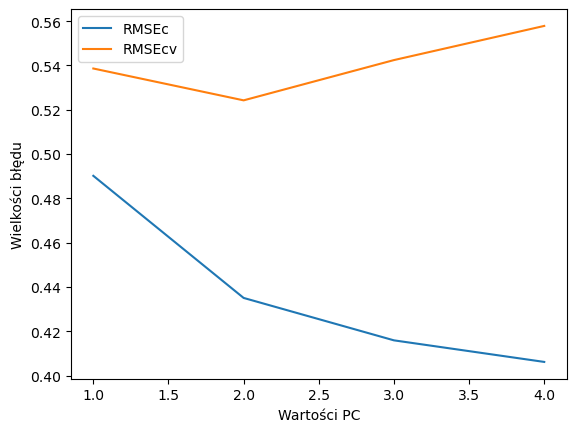

In [100]:
plt.plot(range(1,5), RMSEc, label='RMSEc')
plt.plot(range(1,5), RMSEcv, label='RMSEcv')
plt.xlabel('Wartości PC')
plt.ylabel('Wielkości błędu')
plt.legend()
plt.show()

In [105]:
R2 = model2.score(X_train2, y_train)
Q2ex = (1 - (((y_test - model2.predict(X_test_stand.iloc[:,0:2])))**2).sum()/((y_test - y_test.mean())**2).sum())
RMSEex = np.sqrt((((model2.predict(X_test_stand.iloc[:,0:2]) - y_test)**2).sum())/X_test_stand.iloc[:,0:2].shape[0])

In [106]:
print(f'R2 = {R2}')
print(f'RMSEc = {RMSEc2}')
print(f'Q2ex = {Q2ex}')
print(f'RMSECex = {RMSEex}')

R2 = 0.8555735230410685
RMSEc = 0.43505818283710285
Q2ex = -2.858647393790692
RMSECex = 1.6702957263402587


INTERPRETACJA WYNIKÓW


1. Macierz korelacji-kowariancji 


Znajdują się w niej wartości z przediału ok. abs(0.09;0.64). Są to niskie współczynniki korelacji, więc widząc takie wyniki raczej nie wykonywalibyśmy metody PCR na danych. Metoda PCR jest dla silnie skorelowanych zmiennych. Przyjmuje się graniczną wartość na 0.6-0.7.


2. Główne składowe


Według zastosowanego modelu $PC_1$ wyjaśnia ok 54% wariancji, a $PC_2$ ok. 27%. Po wykonaniu analiz $RMSE_c$ i $RMSE_{cv}$ i przedstawieniu ich na wykresie widać, że po dołączeniu $PC_3$ do modelu jego przewidywania pogarszają się. 


3. Statystyki dla wybranego modelu


Według wspomnianego wyżej wykresu wybrałam model 2 (zawierający 2 główne składowe) i dla niego wykonałam statystyki. $R^2$ oraz $RMSE_{c}$  są w miarę dobre. Według obliczeń $R^2$ wyjaśnia ok 86% zmienności dla wybranych zmiennych. Wartość $Q^2_{ex}$ jest równa ok -2.86, co mówi nam, że model beznadziejnie przewiduje dla innych związków niż treningowe. W przypadku zbioru treningowego średni kwadratowy bład kalibracji jest mniejszy od 1, co teoretycznie mogłoby sugerować dobrze zbudowany model, ale inne staytsyki pokazują, że nie jest to prawdą. Szczególnie statystyka $RMSEC_{ex}$ pokazuje, że model jest przeuczony i nie daje wiarygodnych wyników dla zbioru walidacyjnego.
